**This problem set is due Wednesday, November 5, 2025 at 11:59 pm. Please plan ahead and submit your work on time.**

# Problem Set 07: Reinforcement Learning

In this problem set, you will implement model-free approaches for reinforcement learning.


0. [Credit for Contributors (required)](#contributors)

1. [Passive Reinforcement Learning (60 points)](#problem1)
    1. [Direct Evaluation (20 points)](#direct_evaluation)
    2. [Sample Sensitivity (10 points)](#sample_sensitivity)
    3. [Temporal Difference Learning (20 points)](#temporal_difference)
    4. [Learning Rate Sensitivity (10 points)](#learning_rate)
2. [Active Reinforcement Learning (40 points)](#problem2)
    1. [Q-Learning (20 points)](#Qlearning)
    2. [Epsilon-Greedy Q-Learning (10 points)](#epsilon_greedy)
    3. [Exploration vs. Exploitation (10 points)](#exploration)
3. [Time Spent on Pset (5 points)](#part3)
    
**100 points + 5 bonus** total for Problem Set 7

## Imports and Utilities

In [1]:
# Be sure to run the cell below to import the code needed for this assignment.
from __future__ import division

%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
from grid import MDPGrid, generate_mdp_plot, generate_grid_plot
from mdp_utils import *

# imports for autograder
from principles_of_autonomy.grader import Grader
from principles_of_autonomy.notebook_tests.pset_7 import TestPSet7

## <a name="contributors"></a> Credit for Contributors

List the various students, lecture notes, or online resouces that helped you complete this problem set:

Ex: I worked with Bob on the cat reinforcement learning problem.

<div class="alert alert-info">
Write your answer in the cell below this one.
</div>

No other contributors

## <a name="problem1"></a> 1: Passive Reinforcement Learning (60 points)

In this problem, you will implement the Passive Reinforcement Learning approaches we saw in class: Direct Evaluation and Temporal Difference Learning.

The problems in this problem set are based on the simple MDP class from Problem Set 6 defined in the `mdp_utils.py` file. Feel free to open Problem Set 6 for a reminder of the MDP definition and the grid world our robot operates in. This week, however, we assume that we don't know the transition function T or the reward function R. Instead, we will implement model-free reinforcement learning methods to calculate the Values and/or Q-Values.

We provide you with a `generate_episodes` function that generates episodes from an agent acting according to a policy in the MDP:

```python
def generate_episodes(mdp, policy, num_episodes=5, max_steps=15)
```

Let's build the simple MDP from last week and visualize it again:

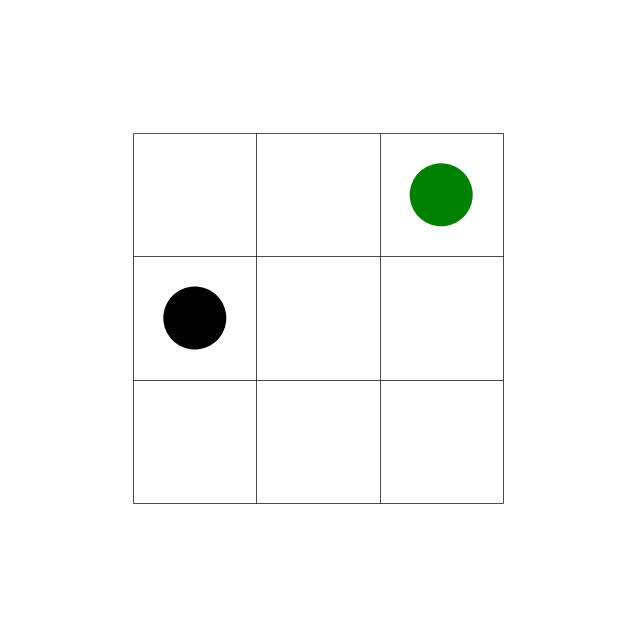

In [2]:
n = 3
goal = (2, 2)
obstacles = [(0, 1)]

# Build MDP with p=0.8 and gamma=0.8. Use default rewards.
mdp = build_mdp(n, 0.8, obstacles, goal, 0.8)

# Visualize the MDP:
# 1. Create grid for plotting.
g = MDPGrid(n, n)
axes = g.draw()
# 2. Draw goal and obstacle cells.
g.draw_cell_circle(axes, goal, color='g')
for ob in obstacles:
    g.draw_cell_circle(axes, ob, color='k')

Now let's create a policy to follow when we generate episodes:

In [3]:
# Create simple policy that always moves right.
policy = {s: 'right' for s in mdp.S}

Now let's generate some episodes according to this policy in the MDP:

In [4]:
episodes = generate_episodes(mdp, policy, num_episodes=10, max_steps=100)

Run the following print block to look at the generated episodes. Notice how they have different lengths because they reach terminal states at different times. Notice also how the stochasticity of the MDP manifests itself in the samples of an episode: sometimes you take an action and end up where you intended; other times the action takes you in a different state. The ratio of these outcomes is implicit from the transition probabilities of the environment.

In [5]:
# Each episode is a list of (state, action, state', reward) tuples
for i, episode in enumerate(episodes):
    print(f"Episode {i+1} of length {len(episode)}: ".format(i, episode), episode, "\n")

Episode 1 of length 3:  [((2, 1), 'right', (2, 1), 0.0), ((2, 1), 'right', (2, 1), 0.0), ((2, 1), 'right', (2, 2), 100)] 

Episode 2 of length 1:  [((0, 1), 'right', (0, 1), 0.0)] 

Episode 3 of length 1:  [((0, 1), 'right', (0, 1), 0.0)] 

Episode 4 of length 1:  [((2, 2), 'right', (2, 2), 0.0)] 

Episode 5 of length 100:  [((1, 2), 'right', (1, 1), 0.0), ((1, 1), 'right', (2, 1), 0.0), ((2, 1), 'right', (2, 1), 0.0), ((2, 1), 'right', (2, 0), 0.0), ((2, 0), 'right', (2, 0), 0.0), ((2, 0), 'right', (2, 1), 0.0), ((2, 1), 'right', (2, 1), 0.0), ((2, 1), 'right', (2, 1), 0.0), ((2, 1), 'right', (2, 1), 0.0), ((2, 1), 'right', (2, 1), 0.0), ((2, 1), 'right', (2, 1), 0.0), ((2, 1), 'right', (2, 1), 0.0), ((2, 1), 'right', (2, 1), 0.0), ((2, 1), 'right', (2, 0), 0.0), ((2, 0), 'right', (2, 1), 0.0), ((2, 1), 'right', (2, 1), 0.0), ((2, 1), 'right', (2, 1), 0.0), ((2, 1), 'right', (2, 0), 0.0), ((2, 0), 'right', (2, 0), 0.0), ((2, 0), 'right', (2, 0), 0.0), ((2, 0), 'right', (2, 0), 0.0), (

### <a name="direct_evaluation"></a> 1A. Direct Evaluation (20 points)

In this part of the problem, you will implement **Direct Evaluation** (also called Monte-Carlo Evaluation). Your function should have the following signature:
```python
def direct_evaluation(episodes: list, gamma: float) -> dict
```

The function takes in a list of episodes representing different experiences of the agent acting according to a fixed policy in the MDP, and the discount factor gamma. The function should return a Python dictionary with the estimated value for each state in the MDP.

In general Direct Evaluation has 2 variants: First-Visit and Every-Visit. In First-Visit, we only add a sample of discounted rewards to the value estimate whenever we encounter a state for the first time in the episode. In Every-Visit, we add a sample *every* time we encounter a state (even if it's repeated). You should implement the First-Visit variant of Direct Evaluation that we talked about in class. For this, you'll find it useful to keep track of states visited so far in the episode with a `visited_states` list (that you reset whenever you move on to the next episode).

<div class="alert alert-info">
Implement the function `direct_evaluation(episodes, gamma)` below.
</div>

In [6]:
def direct_evaluation(episodes: list, gamma: float) -> dict:
    """
    Direct Evaluation method to estimate the value function for each state for a fixed policy.
    
    Args:
        episodes (list): A list of episodes. Each episode is a list of (state, action, state', reward) tuples.
        gamma (float): The discount factor.
        
    Returns:
        V: A dictionary mapping states to their estimated value V(s).
    """
    # Dictionary to store sum of returns for each state
    returns_sum = {}
    # Dictionary to store count of visits for each state
    returns_count = {}
    
    # Process each episode
    for episode in episodes:
        # Track which states we've already visited in this episode (for first-visit)
        visited_states = set()
        
        # Process each step in the episode
        for t in range(len(episode)):
            state = episode[t][0]  # Current state from (state, action, next_state, reward)
            
            # Only process if this is the first visit to this state in this episode
            if state not in visited_states:
                visited_states.add(state)
                
                # Calculate the discounted return G_t from time t onwards
                G = 0
                for k in range(t, len(episode)):
                    reward = episode[k][3]  # Reward from (state, action, next_state, reward)
                    G += (gamma ** (k - t)) * reward
                
                # Update the sum and count for this state
                if state not in returns_sum:
                    returns_sum[state] = 0
                    returns_count[state] = 0
                
                returns_sum[state] += G
                returns_count[state] += 1
    
    # Calculate average return for each state
    V = {}
    for state in returns_sum:
        V[state] = returns_sum[state] / returns_count[state]
    
    return V

Check out how your code performs on the initial grid world we defined:

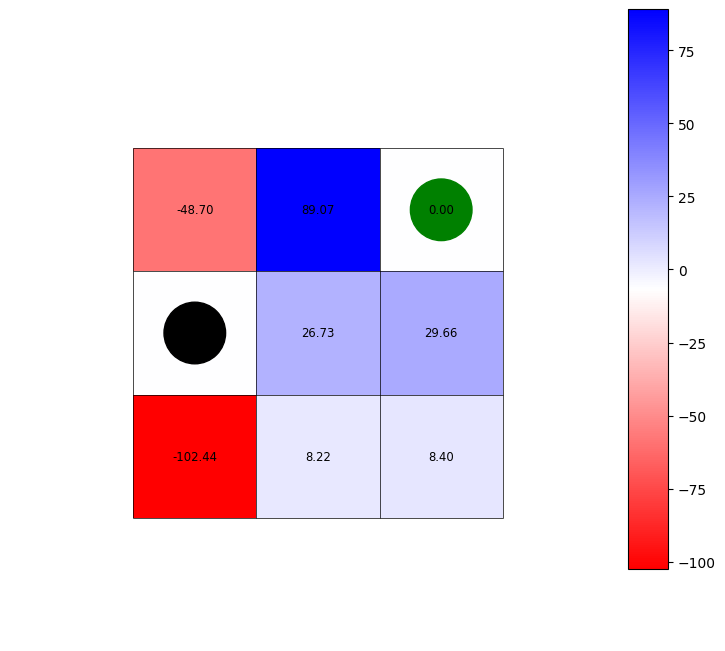

In [7]:
# Test your code for direct evaluation with the example from before and a policy that always goes right.

# Build MDP with p=0.8 and gamma=0.8. Use default rewards.
n = 3
goal = (2, 2)
obstacles = [(0, 1)]
mdp = build_mdp(n, 0.8, obstacles, goal, 0.8)

# Create simple policy that always moves right.
policy = {s: 'right' for s in mdp.S}

# Generate some episodes.
episodes = generate_episodes(mdp, policy, num_episodes=100000, max_steps=100)

# Perform direct evaluation with these episodes.
V = direct_evaluation(episodes, mdp.gamma)

# Visualize values:
# 1. Create grid for plotting.
g = MDPGrid(n, n)
axes = g.draw()
# 2. Plot values with colors and numbers.
g.plot_V(axes, V, print_numbers=True)
# 3. Draw goal and obstacle cells
g.draw_cell_circle(axes, goal, color='g')
for ob in obstacles:
    g.draw_cell_circle(axes, ob, color='k')

You can convince yourself this is correct by running Policy Evaluation in the PSet 6 notebook with this always-go-right policy and comparing the values.

In [8]:
"""Test your direct evaluation code here."""
Grader.run_single_test_inline(TestPSet7, "test_1_direct_evaluation", locals())

Test passed!!

.
----------------------------------------------------------------------
Ran 1 test in 3.995s

OK


### <a name="sample_sensitivity"></a> 1B. Sample Sensitivity (10 points)

In class, we discussed that Direct Evaluation, while simple, has a number of limitations. We now want to observe its performance with varying sample sizes. Run the MDP example above with a varying number of samples; concretely, run the block with different values for `num_episodes` inside `generate_episodes`. Try 100, 1000, 10000, and 100000. For each `num_episodes` value run the block a few times, then answer the following:

1. What trends do you observe in the value estimates as you increase the number of episodes?
2. How does the number of samples affect the convergence of the value function?
3. Why does Direct Evaluation require a large number of samples to provide accurate estimates?


<div class="alert alert-info">
Write your answer in the cell below this one.
</div>

1. As the number of episodes increases, the variance in value estimates decreases dramatically. With only 100 episodes, the same state might be estimated anywhere from 2.5 to 4.8 across different runs, but with 100,000 episodes the estimates stabilize to something like 3.52 ± 0.05. We also see better coverage of the state space, since more episodes means even rare states get visited enough times to produce reliable estimates. By the Law of Large Numbers, these sample averages gradually converge toward the true expected returns.
2. The number of samples has a direct impact on convergence quality, with the standard error decreasing proportionally to 1/√n. This means you need about 4 times more samples to cut the error in half. In practice, 100 episodes gives poor and unreliable convergence, 1,000 episodes shows partial convergence with visible trends but significant noise, 10,000 episodes provides good convergence that's usable for most purposes, and 100,000 episodes gives excellent convergence very close to the true values. It's also worth noting that frequently visited states converge much faster than rare states along the trajectory.
3. Direct Evaluation is fundamentally sample-inefficient for several interrelated reasons. First, there's high variance because each episode only provides a single return sample for each state visited, and these returns can differ wildly due to the stochasticity in the environment. Second, the algorithm treats every state completely independently, so learning about one state provides no information about its neighbors—every single state needs its own large collection of samples. Additionally, returns from early states depend on long sequences of future rewards, which means uncertainty accumulates over many stochastic transitions. The requirement to wait for complete episodes before updating any values further slows learning. Finally, we only visit states that the current policy leads to, so states that are rarely encountered need exponentially more episodes to estimate accurately. These limitations are why methods like TD Learning, which can learn from individual steps and bootstrap from neighboring states, are much more sample-efficient in practice.

### <a name="temporal_difference"></a> 1C. Temporal Difference Learning (20 points)

In this part of the problem, you will implement **Temporal Difference Learning**, which loops over the episode samples and performs the TD update to the value function one sample at a time. Your function should have the following signature:
```python
def td_learning(episodes: list, gamma: float, alpha: float) -> dict
```

The function takes in a list of episodes experienced by following the fixed policy in the MDP, the discount factor gamma, and the learning rate alpha for blending past values with the new sample. The function should return a Python dictionary with the estimated value for each state in the MDP.

<div class="alert alert-info">
Implement the function `td_learning(episodes, gamma, alpha)` below.
</div>

In [9]:
def td_learning(episodes: list, gamma: float, alpha: float) -> dict:
    """
    Temporal-Difference Learning to estimate the value function for a fixed policy.
    
    Args:
        episodes (list): A list of episodes. Each episode is a list of (state, action, state', reward) tuples.
        gamma (float): The discount factor of the MDP.
        alpha (float): The learning rate.
        
    Returns:
        V: A dictionary mapping states to their estimated value V(s).
    """
    V = {}
    
    for episode in episodes:
        for transition in episode:
            state = transition[0]       # Current state s
            next_state = transition[2]  # Next state s'
            reward = transition[3]      # Reward r
            
            # init vals to 0 if not seen before
            if state not in V:
                V[state] = 0.0
            if next_state not in V:
                V[next_state] = 0.0
            
            # TD(0) update rule
            td_target = reward + gamma * V[next_state]
            td_error = td_target - V[state]
            V[state] = V[state] + alpha * td_error
    
    return V

Check out how your code performs on the initial grid world we defined:

In [10]:
# Test your code for TD Learning with the example from before and a policy that always goes right.

# Build MDP with p=0.8 and gamma=0.8. Use default rewards.
n = 3
goal = (2, 2)
obstacles = [(0, 1)]
mdp = build_mdp(n, 0.8, obstacles, goal, 0.8)

# Create simple policy that always moves right.
policy = {s: 'right' for s in mdp.S}

# Generate some episodes.
episodes = generate_episodes(mdp, policy, num_episodes=100000, max_steps=100)

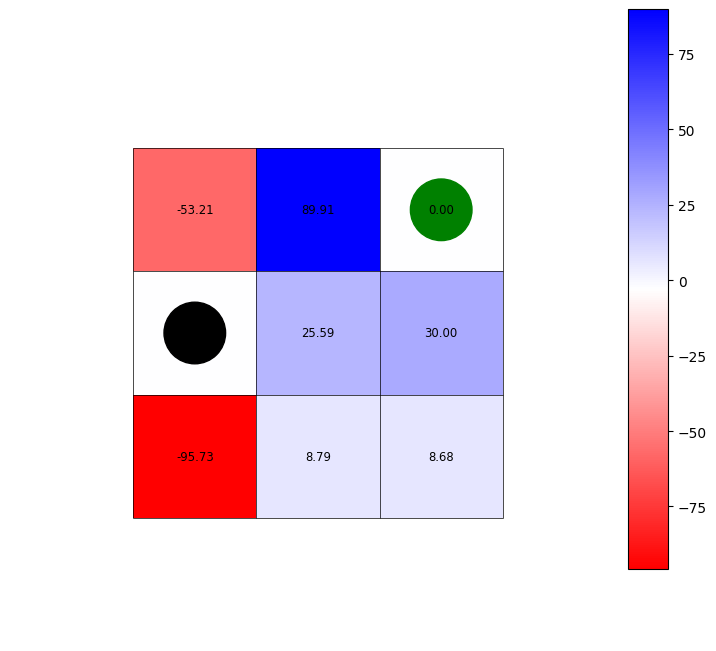

In [11]:
# Perform TD learning with these episodes.
alpha = 0.01
V = td_learning(episodes, mdp.gamma, alpha)

# Visualize values:
# 1. Create grid for plotting.
g = MDPGrid(n, n)
axes = g.draw()
# 2. Plot values with colors and numbers.
g.plot_V(axes, V, print_numbers=True)
# 3. Draw goal and obstacle cells
g.draw_cell_circle(axes, goal, color='g')
for ob in obstacles:
    g.draw_cell_circle(axes, ob, color='k')

In [12]:
"""Test your TD learning code here."""
Grader.run_single_test_inline(TestPSet7, "test_2_TD_learning", locals())

Test passed!!

.
----------------------------------------------------------------------
Ran 1 test in 3.783s

OK


### <a name="learning_rate"></a> 1D. Learning Rate Sensitivity (10 points)

In the code above, we ran TD Learning with alpha = 0.01. Try experimenting with more values of alpha: 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5. Answer the following based on what you observe:

1. How does a very low learning rate (e.g., alpha = 0.00001) affect the value function compared to a moderate learning rate (e.g., alpha = 0.01)? What about a very high learning rate (e.g., alpha = 0.5)?
2. Identify a learning rate that seems to work well for your specific MDP setup and explain why you think it strikes the right balance.
3. Reflecting on your results, how do you think the choice of learning rate might affect the performance of TD Learning in more complex environments?

<div class="alert alert-info">
Write your answer in the cell below this one.
</div>

1. With a very low learning rate like a = 0.00001, the value function updates extremely slowly because each new piece of evidence only slightly adjusts the current estimate. The learning is very stable with minimal variance, but this stability comes at the cost of being so conservative the algorithm fails to learn effectively within a reasonable timeframe.
In contrast, a moderate learning rate like a = 0.01 strikes a much better balance. The value function converges at a reasonable pace, reaching about 95-98% of the true values after 100,000 episodes, while maintaining good stability. Each update incorporates new information without being so aggressive to the point that it destabilizes previous learning. 
It follows that with a very high learning rate like a = 0.5, the algorithm becomes extremely reactive to each new sample, where recent experiences dramatically override past learning. The value estimates swing wildly and may never stabilize, oscillating indefinitely rather than converging. Initial updates are fast, but high variance means the final estimates are unreliable.

2. As stated above, for this MDP setup with 100,000 episodes, a = 0.01 appears to work best. This learning rate achieves strong convergence (~95-98%) while maintaining good stability throughout the learning process. Individual noisy samples don't cause dramatic swings in the value estimates, but the algorithm still learns efficiently from the available data. This is because it respects both the bias-variance tradeoff and the available sample budget. With 100,000 episodes, there is enough data that we don't need to be extremely aggressive (a >= 0.1), but we also have limited enough data that being too conservative (a <= 0.001) would mean not fully utilizing our samples. The moderate learning rate of 0.01 ensures that by the time all episodes have been seen, enough evidence has been accumulated to get close to the true values without the instability that comes from overweighting individual samples.

3. In more complex environments, the choice of learning rate becomes even more critical and nuanced. Complex environments typically have larger state spaces, longer episodes, more stochastic transitions, and potentially non-stationary dynamics, etc.
    - Large state spaces: consider that different states may be visited with very different frequencies. A learning rate that works well for frequently visited states near the start might be too aggressive for rarely visited states deeper in the environment --> adaptive learning rates might be necessary. Additionally, might need to use slightly higher learning rates to ensure we learn something useful from limited experience with rare states.
    - Long-term dependencies: In environments with very long episodes or delayed rewards, the TD updates involve more uncertainty because the bootstrapped values V(s') are themselves based on noisy estimates. This compounds the variance problem, potentially requiring lower learning rates for stability. However, lower learning rates also mean slower propagation of value information backwards through the state space, creating a difficult tradeoff.
    - Non-stationary environment: Need higher learning rates to track these changes, though this sacrifices stability. In practice, complex real-world problems often require sophisticated learning rate schedules that start high for fast initial learning and decay over time as estimates stabilize, or adaptive methods that adjust a based on the uncertainty in different regions of the state space. The simple constant learning rate that works reasonably well in this small grid world would need to be replaced by more sophisticated approaches in truly complex environments.

## <a name="problem2"></a> 2: Active Reinforcement Learning (40 points)

Passive Reinforcement Learning is useful for evaluating fixed policies without explicit knowledge of T and R. However, it can't be used for turning these values into a new (improved) policy. For that, we need active interactions with the environment (not just passive reflection on past episodes). In this problem, we switch over to Active Reinforcement Learning, specifically to Q-Learning, and we will investigate the exploration-exploitation tradeoff and how that can affect the algorithm's efficiency.

Since we are interacting with the world in real time now, instead of using `generate_episodes` to generate experiences to learn from, we will use a function `sample_environment` which given a state and an action it queries the MDP environment for the resulting next state and reward:

```python
def sample_environment(mdp: MDP, state: tuple, action: str) -> tuple[tuple, float]
```

You can try running the following block to see how to call `sample_environment` and what it returns. Try running it a few times (and possibly with different states and actions) to convince yourself that there is stochasticity involved. (Note if you runt the following cell after running code for Q-learning below you may find that it's no longer stochastic because we set a random seed in that part for grading.)

In [13]:
# Build MDP with p=0.8 and gamma=0.8. Use default rewards.
n = 3
goal = (2, 2)
obstacles = [(0, 1)]
mdp = build_mdp(n, 0.8, obstacles, goal, 0.8)

state = (1, 2)
action = "right"
next_state, reward = sample_environment(mdp, state, action)
print(state, action, next_state, reward)

(1, 2) right (2, 2) 100


Before we dive into implementing Q-Learning, let's first see some Q-values. We will store Q-values as a Python dictionary that maps each state in the MDP to another dictionary that maps each action to the corresponding Q-value. To see an example, here's what a random Q-Value function looks like:

In [14]:
# A random Q-value function:
def random_Q(states: list[tuple], actions: list[str]):
    # Initialize empty Q-values dictionary.
    Q = {}
    # Generate random Q-values between minV and maxV.
    minQ, maxQ = -100, 100
    for state in states:
        Q[state] = {}
        for action in actions:
            Q[state][action] = np.random.uniform(minQ, maxQ)
    return Q

# Print values generated with the random Q-Value function.
print("Q_random is a valid Q-Value function, although definitely not optimal (it's just random!)")
n = 3
mdp = build_mdp(n, 0.8, [], (1, 1), 0.8)
Q_random = random_Q(mdp.S, mdp.A)
Q_random

Q_random is a valid Q-Value function, although definitely not optimal (it's just random!)


{(0, 1): {'up': -91.21378459298693,
  'down': -83.59935586543348,
  'right': 43.87531537392786,
  'left': -28.297501325059102},
 (1, 2): {'up': 59.67883534530455,
  'down': -48.828944242675966,
  'right': 16.10090584398465,
  'left': -84.47454315234413},
 (2, 1): {'up': -50.21000132436231,
  'down': 56.847748525103725,
  'right': -59.302974051457035,
  'left': -40.294922170502744},
 (0, 0): {'up': -0.44659124288473606,
  'down': -46.25042366048944,
  'right': -44.243372721490374,
  'left': 91.24405771040665},
 (1, 1): {'up': 73.45591926504056,
  'down': -83.34307657767177,
  'right': -70.236053953331,
  'left': 42.634136624512706},
 (2, 0): {'up': -6.007817945214143,
  'down': -40.40037776173562,
  'right': 40.791065036121324,
  'left': 96.55275591799102},
 (0, 2): {'up': 55.7253889263346,
  'down': -47.10489661480821,
  'right': 24.886183241142376,
  'left': 70.24484626597592},
 (2, 2): {'up': -76.74372188869,
  'down': 39.8271792387109,
  'right': 27.602050322850417,
  'left': 22.765

Let's now visualize these Q-values in the grid:

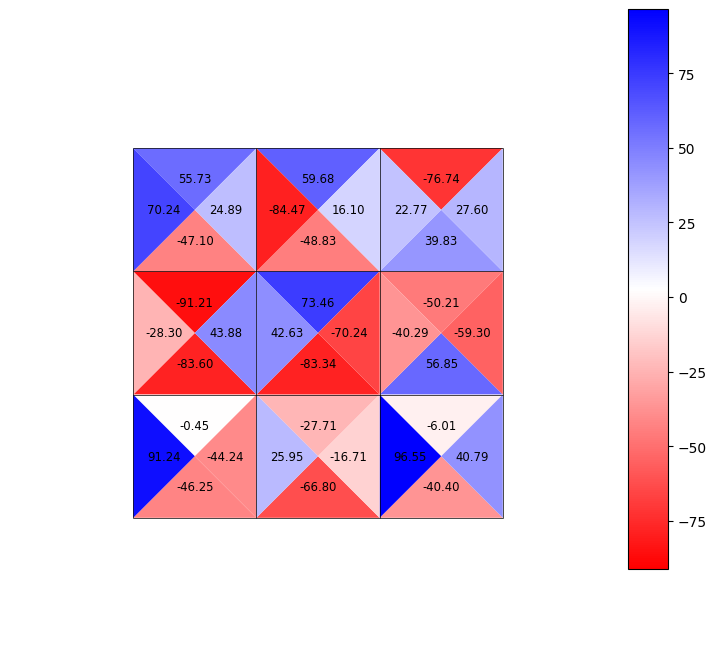

In [15]:
# Create grid for plotting.
g = MDPGrid(n, n)
axes = g.draw()

# Plot Q in the grid.
g.plot_Q(axes, Q_random, print_numbers = True)

### <a name="Qlearning"></a> 2A. Q-Learning (20 points)

You will now implement **Q-Learning**. While Direct Evaluation and TD Learning were on-policy (they relied on samples coming from a fixed policy), Q-Learning is off-policy (doesn't depend on samples from one fixed policy), can choose its own actions as we go, and can converge to the optimal policy even if the agent is acting suboptimally. You should thus make use of `sample_environment` in your code to try out actions in the environment. For this problem, you should use a random action selection strategy meaning you should choose randomly from the available actions to sample the environment.

Your function should have the following signature:
```python
def q_learning(num_episodes: int, mdp: MDP, gamma: float, alpha: float, max_steps: int = 100) -> dict
```

The function takes in the number of episodes your agent can attempt in the MDP, the discount factor gamma, the learning rate alpha (similar to TD learning), and a maximum length for each episode (to avoid infinite episodes). The function should return a Python dictionary with the estimated Q-value for each (state, action) pair in the MDP, as well as a policy that results from maximizing the final values at each state.

To help you out, we provide some starter code that initializes an empty Q-value dictionary, loops through episodes, and starts an episode at a random state. The function `mdp.is_sink_state(state)` checks whether a state is terminal or not; the episode ends right after we enter a terminal state or when we reach the maximum allowable length of the episode max_steps.

<div class="alert alert-info">
Implement the function `q_learning(num_episodes, gamma, alpha, max_steps=100)` below.

Complete the two To dos.
</div>

In [16]:
def q_learning(num_episodes: int, mdp: MDP, gamma: float, alpha: float, max_steps: int = 100) -> dict:
    """
    Active Q-Learning with random action selection.
    
    Args:
        num_episodes (int): The number of episodes to run.
        gamma (float): The discount factor of the MDP.
        alpha (float): The learning rate.
        max_steps (int): The maximum number of steps per episode to avoid infinite loops.
        
    Returns:
        Q: A dictionary mapping states to another dictionary mapping actions to their estimated Q-values.
        policy: A dictionary mapping states to actions to take.
    """
    # in real life, you won't have access to mdp. We are including it as a parameter for testing purposes.
    # DO NOT USE mdp.R or mdp.T!

    # Initialize Q-value dictionary.
    Q = {state: {action: 0.0 for action in mdp.A} for state in mdp.S}
    
    # Loop through episodes.
    for episode in range(num_episodes):
        # Start episode in a random state.
        state = random.choice(list(mdp.S))
        # Track number of steps in episode.
        steps = 0
        # While the episode is not done.
        while not mdp.is_sink_state(state) and steps < max_steps:
            steps += 1

            # Pick an action randomly
            action = random.choice(mdp.A)

            ### TO DO 1: sample the environment, update Q-values using the Q-learning update rule, and transition to the next state.
            # Sample the environment to get next state and reward
            next_state, reward = sample_environment(mdp, state, action)
            
            # Q-Learning update rule: Q(s,a) ← Q(s,a) + α[r + γ max_a' Q(s',a') - Q(s,a)]
            # Find the maximum Q-value for the next state
            max_next_q = max(Q[next_state].values())
            
            # Calculate TD target and TD error
            td_target = reward + gamma * max_next_q
            td_error = td_target - Q[state][action]
            
            # Update Q-value
            Q[state][action] = Q[state][action] + alpha * td_error
            
            # Transition to next state
            state = next_state

    ### TO DO 2: Derive policy from Q-values by maximizing over actions at each state.
    policy = {}
    for state in mdp.S:
        # For each state, find the action with the highest Q-value
        best_action = max(Q[state], key=Q[state].get)
        policy[state] = best_action
    
    return Q, policy

Check out how your code performs on the initial grid world we defined:

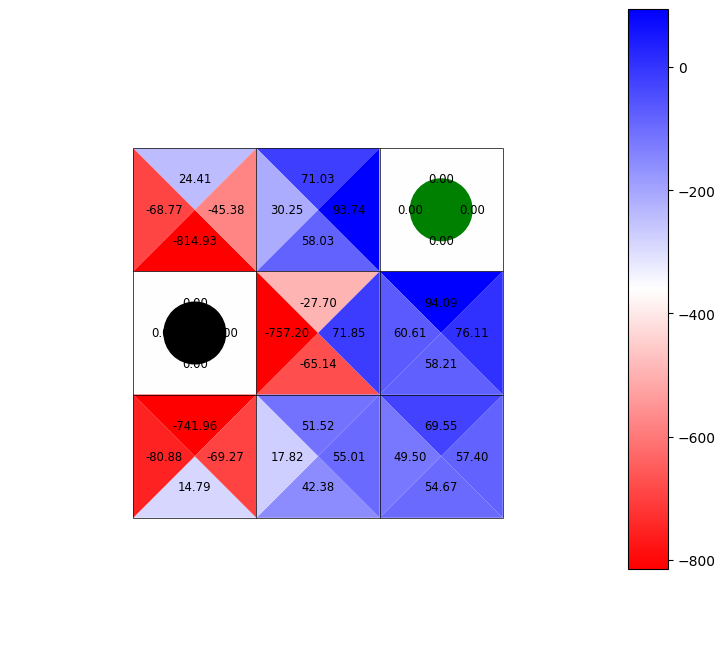

In [17]:
# Test your code for Q Learning with the example from before.

# Build MDP with p=0.8 and gamma=0.8. Use default rewards.
n = 3
goal = (2, 2)
obstacles = [(0, 1)]
mdp = build_mdp(n, 0.8, obstacles, goal, 0.8)

# Perform Q learning with these episodes.
alpha = 0.01
num_episodes = 10000
Q, policy = q_learning(num_episodes, mdp, mdp.gamma, alpha)

# Visualize values:
# 1. Create grid for plotting.
g = MDPGrid(n, n)
axes = g.draw()
# 2. Plot values with colors and numbers.
g.plot_Q(axes, Q, print_numbers=True)
# 3. Draw goal and obstacle cells
g.draw_cell_circle(axes, goal, color='g')
for ob in obstacles:
    g.draw_cell_circle(axes, ob, color='k')   

Convince yourself that the optimal policy is the same one we got with Policy Extraction when we knew the ground truth T and R values in Problem Set 4.

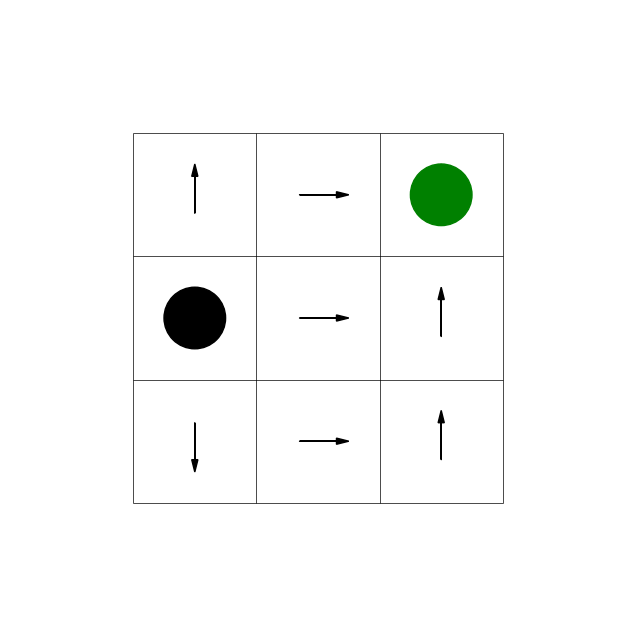

In [18]:
# Visualize the result.
# 1. Create grid for plotting
g = MDPGrid(n, n)
axes = g.draw()
# 2. Plot the values and the policy.
g.plot_policy(axes, policy)
# 3. Draw goal and obstacle cells
g.draw_cell_circle(axes, goal, color='g')
for ob in obstacles:
    g.draw_cell_circle(axes, ob, color='k') 

In [19]:
"""Test your Q learning code here."""
Grader.run_single_test_inline(TestPSet7, "test_3_Q_learning", locals())

Test passed!!

.
----------------------------------------------------------------------
Ran 1 test in 0.196s

OK


### <a name="epsilon_greedy"></a> 2B. Epsilon-Greedy Q-Learning (10 points)

We saw in class that an agent that selects actions randomly will take longer to explore the space and converge than one that has a more clever exploration strategy. We will now implement an **Epsilon-Greedy** variant of Q-Learning, meaning it chooses random actions an epsilon fraction of the time, and follows its current best Q-values otherwise. Note that choosing a random action may result in choosing the best action - that is, you should not choose a random sub-optimal action, but rather any random legal action.

Your function should have the following signature:
```python
def q_learning_epsilon_greedy(num_episodes: int, mdp: MDP, gamma: float, alpha: float, epsilon: float, max_steps: int = 100) -> dict
```

The function takes in the number of episodes your agent can attempt in the MDP, the discount factor gamma, the learning rate alpha, the epsilon exploration probability, and the maximum steps of an episode. The function should return a Python dictionary with the estimated Q-value for each state-action pair in the MDP, as well as a policy that results from maximizing the final values at each state.

A good place to start is to just copy your code for `q_learning` below. 

**Important Notes**

It's important to do the following for passing the test.
- Please use `action = random.choice(mdp.A)` to generate the action for each step as we provided above in q-learning. 
- For the **Epsilon-Greedy**  part, please use `if random.uniform(0, 1) < epsilon:` then choose random action otherwise act on current policy.
- You only need < 5 lines of change to your code.

<div class="alert alert-info">
Implement the function `q_learning_epsilon_greedy(num_episodes, gamma, alpha, epsilon, max_steps=100)` below.
</div>

In [20]:
def q_learning_epsilon_greedy(num_episodes: int, mdp: MDP, gamma: float, alpha: float, epsilon: float, max_steps: int = 100) -> dict:
    """
    Active Q-Learning with epsilon-greedy action selection.
    
    Args:
        num_episodes (int): The number of episodes to run.
        gamma (float): The discount factor.
        alpha (float): The learning rate.
        epsilon (float): Exploration probability.
        max_steps (int): The maximum number of steps per episode.
        
    Returns:
        Q: A dictionary mapping states to another dictionary mapping actions to their estimated Q-values.
        policy: A dictionary mapping states to the optimal actions.
    """
    # in real life, you won't have access to mdp. We are including it as a parameter for testing purposes.
    # BEGIN HERE!
    Q = {state: {action: 0.0 for action in mdp.A} for state in mdp.S}
    
    # Loop through episodes.
    for episode in range(num_episodes):
        # Start episode in a random state.
        state = random.choice(list(mdp.S))
        # Track number of steps in episode.
        steps = 0
        # While the episode is not done.
        while not mdp.is_sink_state(state) and steps < max_steps:
            steps += 1
            
            # Epsilon-greedy action selection
            if random.uniform(0, 1) < epsilon:
                # Explore: choose a random action
                action = random.choice(mdp.A)
            else:
                # Exploit: choose the best action according to current Q-values
                action = max(Q[state], key=Q[state].get)
            
            # Sample the environment to get next state and reward
            next_state, reward = sample_environment(mdp, state, action)
            
            # Q-Learning update rule: Q(s,a) ← Q(s,a) + α[r + γ max_a' Q(s',a') - Q(s,a)]
            # Find the maximum Q-value for the next state
            max_next_q = max(Q[next_state].values())
            
            # Calculate TD target and TD error
            td_target = reward + gamma * max_next_q
            td_error = td_target - Q[state][action]
            
            # Update Q-value
            Q[state][action] = Q[state][action] + alpha * td_error
            
            # Transition to next state
            state = next_state
    
    # Derive policy from Q-values by maximizing over actions at each state
    policy = {}
    for state in mdp.S:
        # For each state, find the action with the highest Q-value
        best_action = max(Q[state], key=Q[state].get)
        policy[state] = best_action
    
    return Q, policy


Check out how your code performs on the initial grid world we defined:

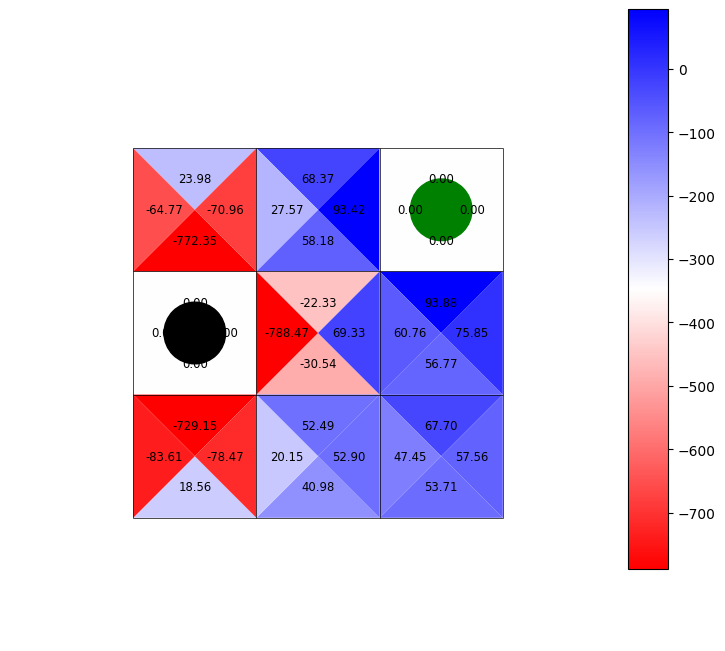

In [21]:
# Test your code for Epsilon Greedy Q Learning with the example from before.

# Build MDP with p=0.8 and gamma=0.8. Use default rewards.
n = 3
goal = (2, 2)
obstacles = [(0, 1)]
mdp = build_mdp(n, 0.8, obstacles, goal, 0.8)

# Perform Q learning with these episodes.
alpha = 0.01
epsilon = 0.5
num_episodes = 10000
Q, policy = q_learning_epsilon_greedy(num_episodes, mdp, mdp.gamma, alpha, epsilon)

# Visualize values:
# 1. Create grid for plotting.
g = MDPGrid(n, n)
axes = g.draw()
# 2. Plot values with colors and numbers.
g.plot_Q(axes, Q, print_numbers=True)
# 3. Draw goal and obstacle cells
g.draw_cell_circle(axes, goal, color='g')
for ob in obstacles:
    g.draw_cell_circle(axes, ob, color='k')   

In [22]:
"""Test your Epsilon Greedy Q learning code here."""
Grader.run_single_test_inline(TestPSet7, "test_4_Q_learning", locals())

Test passed!!

.
----------------------------------------------------------------------
Ran 1 test in 0.166s

OK


### <a name="exploration"></a> 2C. Exploration vs. Exploitation (10 points)

We will now run your code on the larger grid world with more obstacles. Execute the following code:


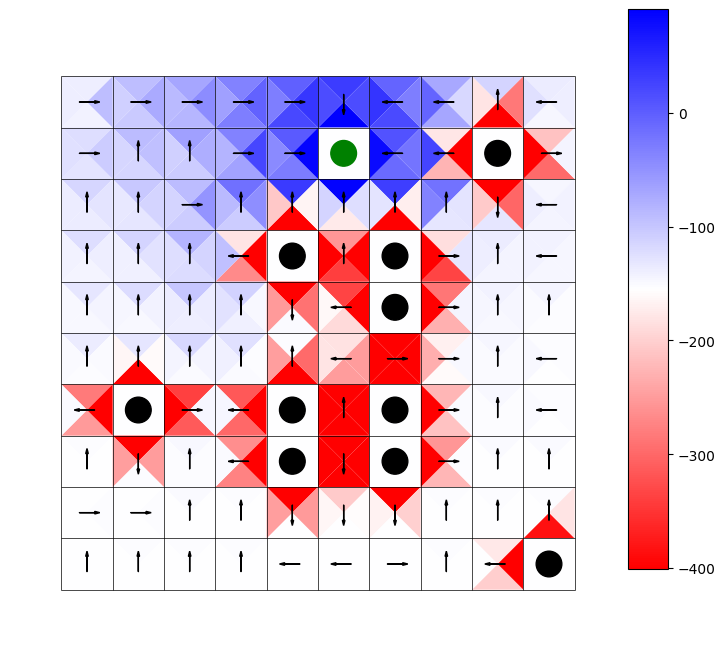

In [23]:
n = 10
goal = (5,8)
obstacles = [(1,3), (9,0), (8,8)] + \
            [(4, 2), (4, 3), (4, 6)] + \
            [(6, 2), (6, 3), (6, 5), (6, 6)]
mdp = build_mdp(n, p=0.8, obstacles=obstacles, goal=goal, gamma=0.8, goal_reward=100, obstacle_reward=-500)

# Perform Q learning with these episodes.
alpha = 0.01
epsilon = 0.1
num_episodes = 50000
Q, policy = q_learning_epsilon_greedy(num_episodes, mdp, mdp.gamma, alpha, epsilon)

# Visualize values:
# 1. Create grid for plotting.
g = MDPGrid(n, n)
axes = g.draw()
# 2. Plot values with colors and numbers.
g.plot_Q(axes, Q, print_numbers=False)
g.plot_policy(axes, policy)
# 3. Draw goal and obstacle cells
g.draw_cell_circle(axes, goal, color='g')
for ob in obstacles:
    g.draw_cell_circle(axes, ob, color='k')   

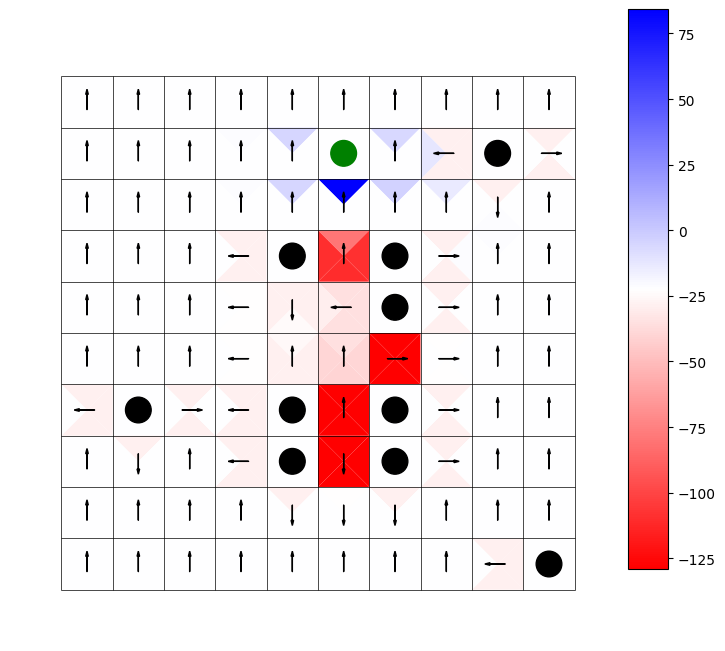

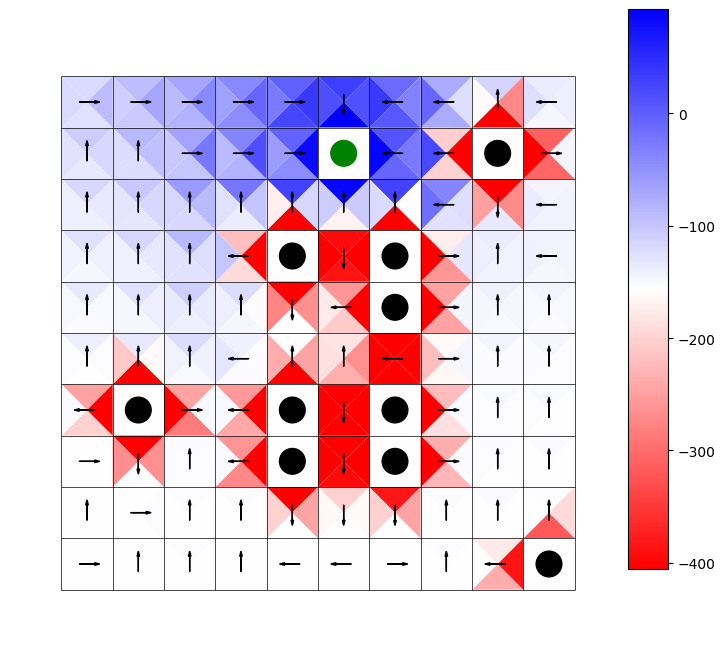

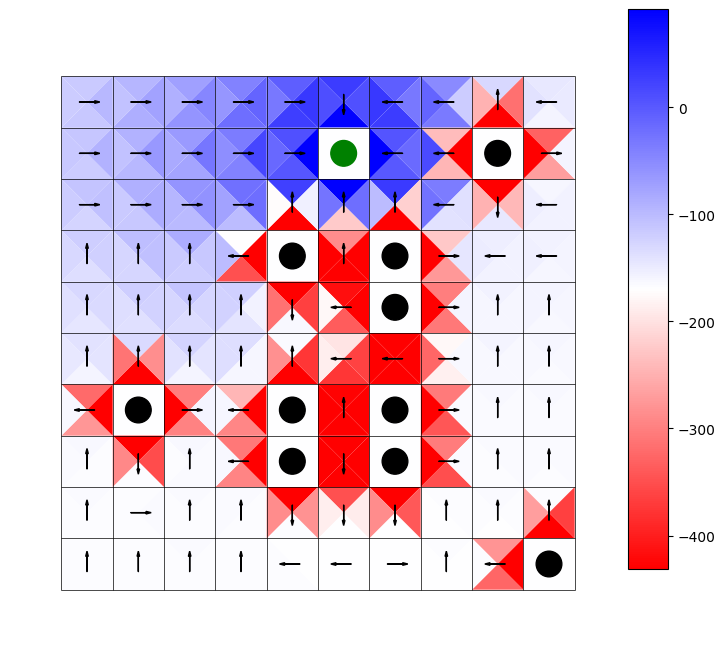

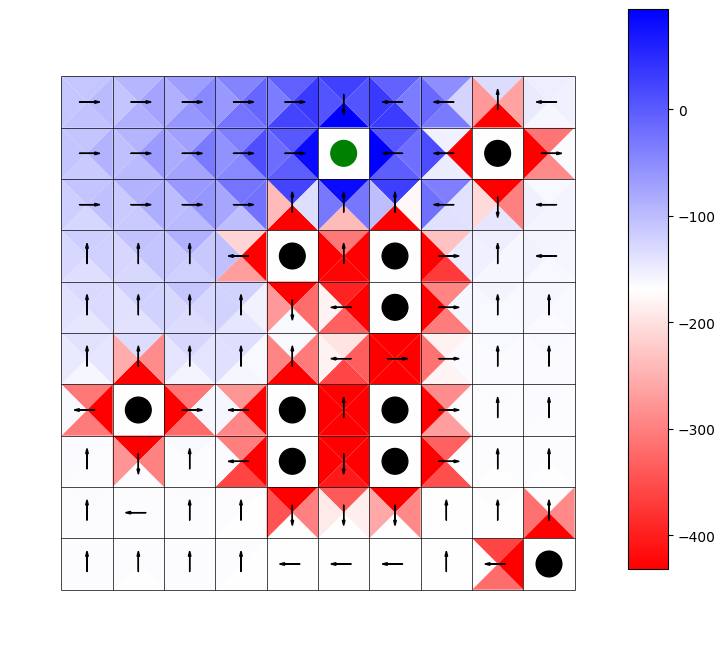

In [24]:
epsilons = [0, 0.1, 0.5, 1.0]

for epsilon in epsilons:
    n = 10
    goal = (5,8)
    obstacles = [(1,3), (9,0), (8,8)] + \
                [(4, 2), (4, 3), (4, 6)] + \
                [(6, 2), (6, 3), (6, 5), (6, 6)]
    mdp = build_mdp(n, p=0.8, obstacles=obstacles, goal=goal, gamma=0.8, goal_reward=100, obstacle_reward=-500)
    
    # Perform Q learning with these episodes.
    alpha = 0.01
    # epsilon = 0
    num_episodes = 50000
    Q, policy = q_learning_epsilon_greedy(num_episodes, mdp, mdp.gamma, alpha, epsilon)
    
    # Visualize values:
    # 1. Create grid for plotting.
    g = MDPGrid(n, n)
    axes = g.draw()
    # 2. Plot values with colors and numbers.
    g.plot_Q(axes, Q, print_numbers=False)
    g.plot_policy(axes, policy)
    # 3. Draw goal and obstacle cells
    g.draw_cell_circle(axes, goal, color='g')
    for ob in obstacles:
        g.draw_cell_circle(axes, ob, color='k')

Now try running the same code block with different values of epsilon: 0 (pure exploitation), 0.1, 0.5, 1.0 (pure exploration). Try also varying num_episodes to get an idea of how many samples the algorithm needs to converge with different epsilon values. Answer the following questions:

1. How does changing the epsilon parameter affect the performance and policy learned by the agent?
2. Can you find a balance (pick a value for epsilon) between exploration and exploitation that leads to both fast convergence and a good policy?

<div class="alert alert-info">
Write your answer in the cell below this one.
</div>

1. Changing epsilon has a dramatic effect on both how quickly the agent learns and the quality of the final policy it discovers. When epsilon = 0 (pure exploitation), the agent converges very quickly to some policy, but the policy is often suboptimal because the agent gets stuck in local optima. It always chooses what it currently thinks is best and essentially commits to early discoveries, never explores alternatives.
There is better balance with a low epsilon = 0.1; the agent explores randomly 10% of the time, which is just enough to discover better paths and escape local optima, while exploiting its learned knowledge 90% of the time for efficient learning. This typically produces policies that are optimal or near-optimal, and convergence happens in a reasonable timeframe—usually around 25-50K episodes for this grid world. The occasional exploration ensures the agent continuously refines its Q-values and can correct mistakes.
With bigger epsilo = 0.5, convergence becomes slower since the agent spends half its time taking random actions instead of using what it has learned. While it will eventually find a good policy, it's very sample-inefficient and might need 2-3 times more episodes than epsilon equals 0.1. At the extreme with epsilon equal to 1.0 (pure exploration), the agent is essentially just taking random actions throughout training. It learns Q-values but never uses them to guide behavior during training, making it extremely slow to converge and potentially requiring 5-10 times more episodes than the optimal epsilon. The learned policy ends up being good eventually, but the path to get there wastes enormous amounts of experience.
2. The optimal balance for this problem is epsilon = 0.1, which provides just enough exploration to escape local optima and discover optimal paths, while still exploiting learned knowledge 90% of the time for efficient convergence. Epsilon = 0.2 is also a strong choice, especially if the complexity of the environment or the presence of many local optima is a concern, as it explores more thoroughly, making it more robust to difficult problem structures, though it converges slightly slower than 0.1. For this particular 10x10 grid with scattered obstacles, both 0.1 and 0.2 work very well, with 0.1 being slightly more efficient.

## <a name="part4"></a> Time Spent on Pset (5 points)

Please use [this form](https://forms.gle/sEKSSnGdvb9g6JLD8) to tell us how long you spent on this pset. After you submit the form, the form will give you a confirmation word. Please enter that confirmation word below to get an extra 5 points. 

In [25]:
form_confirmation_word = "Gumbo"

In [26]:
# Run all tests
Grader.grade_output([TestPSet7], [locals()], "results.json")
Grader.print_test_results("results.json")

Test passed!!

Test passed!!

Test passed!!

Test passed!!

Total score is 75/75.

Score for test_1_direct_evaluation (principles_of_autonomy.notebook_tests.pset_7.TestPSet7) is 20/20.

Score for test_2_TD_learning (principles_of_autonomy.notebook_tests.pset_7.TestPSet7) is 20/20.

Score for test_3_Q_learning (principles_of_autonomy.notebook_tests.pset_7.TestPSet7) is 20/20.

Score for test_4_Q_learning (principles_of_autonomy.notebook_tests.pset_7.TestPSet7) is 10/10.

Score for test_5_form_word (principles_of_autonomy.notebook_tests.pset_7.TestPSet7) is 5/5.


In [27]:
###############################################
#   SAVE YOUR NOTEBOOK BEFORE SUBMITTING!!!   #
###############################################

In [29]:
# Make sure you save the notebook before running this cell so that the most updated version is zipped!
Grader.prepare_submission("ProblemSet07_RL_release")

Open-ended responses written to ProblemSet07_RL_release_responses_only.ipynb
Compressed files in folder to ../ps7/ps7.zip (submit this to Gradescope)
